# Test against just two classes 

In this notebook we will take in our data from CitiBike and organize down to just one start station and two end neighborhoods. The goal is to test if we can better predict on a question with fewer target classes. 

To do this we will test the Xgboost classifier and use the same variables we have for other trials. 

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Create a DF with neighborhoods connected to Stations.

In [2]:
neighborhoods = pd.read_csv('citibike_data/citibike_neighborhoods.csv')

In [3]:
neighborhoods['end station name'] = neighborhoods['stops']
neighborhoods = neighborhoods[['end station name', 'stop_nhbr']]

### Import and Pull only data from a single station start and two destinations. 

In [4]:
for i in range(1,13):
    if i == 1:
        big = pd.read_csv('citibike_data/2018'+ str(i).zfill(2)+'-citibike-tripdata.csv')
        big = pd.merge(big, neighborhoods, on='end station name', how='left')
        big = big[(big['start station id']==490) & ((big['stop_nhbr']=='Upper West Side') 
       |(big['stop_nhbr']=='East Village'))]
        #big = big.sample(frac=.1)
    else:
        temp = pd.read_csv('citibike_data/2018'+ str(i).zfill(2)+'-citibike-tripdata.csv')
        temp = pd.merge(temp, neighborhoods, on='end station name', how='left')
        temp = temp[(temp['start station id']==490) & ((temp['stop_nhbr']=='Upper West Side') 
       |(temp['stop_nhbr']=='East Village'))]
        big = pd.concat([big, temp])

In [5]:
big = big.dropna()

In [6]:
big.usertype = pd.Categorical(big.usertype)
big.usertype = big.usertype.cat.codes

In [7]:
big['starttime'] = pd.to_datetime(big['starttime'])
big['start_month'] = big.starttime.dt.month
big['start_day_of_week'] = big.starttime.dt.dayofweek
big['start_hour'] = big.starttime.dt.hour
big['start_date'] = big.starttime.dt.day

big['starttime'] = big.starttime.dt.date
big['starttime'] = pd.to_datetime(big['starttime'])

In [8]:
weather_df = pd.read_csv('citibike_data/2018_weather.csv')
weather_df['starttime'] = pd.to_datetime(weather_df['date'])
weather_df = weather_df.drop(['max_temp', 'min_temp','departure', 'Hdd', 'cdd', 'new_snow', 'date' ], axis=1)

In [9]:
big = pd.merge(big, weather_df, on='starttime', how='left')

In [10]:
big = big.drop(['starttime', 'stoptime','start station name',
                'end station id', 'bikeid', 'start station latitude', 
                'start station longitude', 'end station latitude', 
                'end station longitude','end station name', 'start_date'], axis=1)

In [14]:
df2=big

### Confusion Matrix function: 

In [13]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    plt.figure(figsize=(20,12))
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

### Test of dropping tripduration:

Split variables from targets: 

In [15]:
labels = df2.stop_nhbr

Use LabelEncoder to convert target labels into a categories: 

In [16]:
# le = LabelEncoder()

In [17]:
# labels = le.fit_transform(labels.astype(str))
labels_removed_df = df2.drop('stop_nhbr', axis=1)

Scale data: 

In [18]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(labels_removed_df.astype(float))

Split data into training and testing sets. Maintain at least some of each target class in both sets with the 'stratify' argument.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels)

Fit xgboost model:

In [28]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=4, min_child_weight=5, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=4, min_child_weight=5, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [30]:
training_preds = clf.predict(X_train)

In [31]:
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 89.87%
Validation accuracy: 69.98%


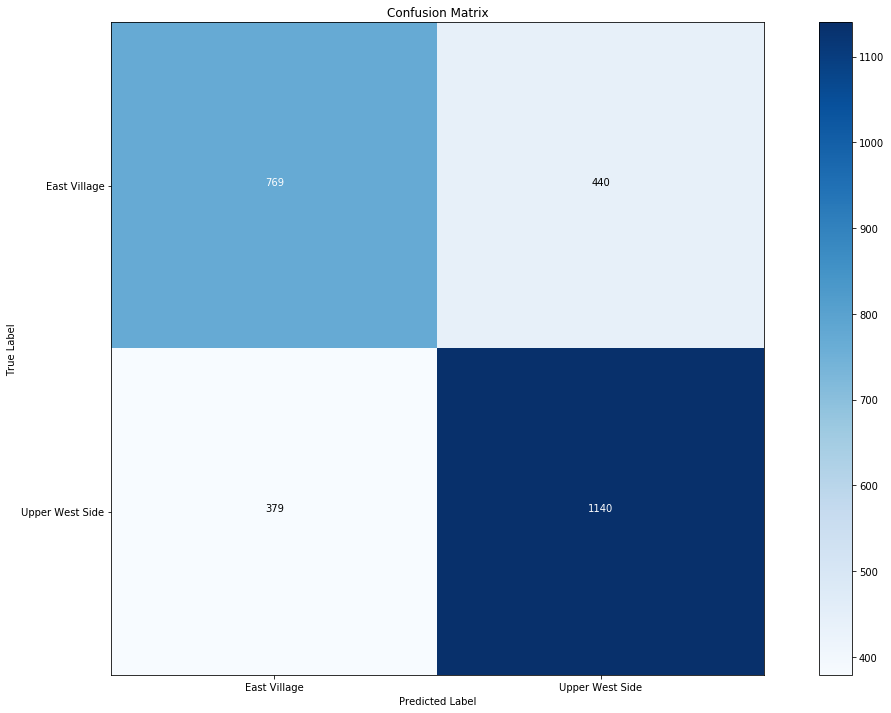

In [32]:
show_cf(y_test, val_preds)

In [25]:
param_grid = {
    "learning_rate": [0.5, 0.7, 0.1],
    'max_depth': [2, 3, 4],
    'min_child_weight': [4, 5],
    'n_estimators': [300, 400, 500],
}

In [ ]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
eval_metric = ["auc", 'error']
eval_set = [(X_train, y_train), (X_test, y_test)]
grid_clf.fit(X_train, y_train, eval_set= eval_set, early_stopping_rounds=20)
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

[0]	validation_0-error:0.356549	validation_1-error:0.358504
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.347385	validation_1-error:0.355572
[2]	validation_0-error:0.356549	validation_1-error:0.358504
[3]	validation_0-error:0.347752	validation_1-error:0.354106
[4]	validation_0-error:0.348851	validation_1-error:0.355205
[5]	validation_0-error:0.33871	validation_1-error:0.352273
[6]	validation_0-error:0.337977	validation_1-error:0.34934
[7]	validation_0-error:0.338343	validation_1-error:0.34824
[8]	validation_0-error:0.334066	validation_1-error:0.345308
[9]	validation_0-error:0.330156	validation_1-error:0.341276
[10]	validation_0-error:0.331745	validation_1-error:0.342742
[11]	validation_0-error:0.330767	validation_1-error:0.343475
[12]	validation_0-error:0.327835	validation_1-error:0.344575
[13]	validation_0-error:0.326857	validation_1-error:0.34530

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[37]	validation_0-error:0.30413	validation_1-error:0.337243
[38]	validation_0-error:0.304497	validation_1-error:0.336877
[39]	validation_0-error:0.303397	validation_1-error:0.335777
[40]	validation_0-error:0.303397	validation_1-error:0.335411
[41]	validation_0-error:0.303397	validation_1-error:0.335044
[42]	validation_0-error:0.30303	validation_1-error:0.335411
[43]	validation_0-error:0.302786	validation_1-error:0.334311
[44]	validation_0-error:0.302297	validation_1-error:0.335044
Stopping. Best iteration:
[24]	validation_0-error:0.312805	validation_1-error:0.330279

[0]	validation_0-error:0.352273	validation_1-error:0.353372
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.340787	validation_1-error:0.348974
[2]	validation_0-error:0.344697	validation_1-error:0.353372
[3]	validation_0-error:0.352273	validation_1-error:0.353372
[4]	validation_0-error:0.

[18]	validation_0-error:0.319526	validation_1-error:0.341276
[19]	validation_0-error:0.318793	validation_1-error:0.337977
[20]	validation_0-error:0.31806	validation_1-error:0.33651
[21]	validation_0-error:0.315494	validation_1-error:0.331745
[22]	validation_0-error:0.316227	validation_1-error:0.332478
[23]	validation_0-error:0.314638	validation_1-error:0.331012
[24]	validation_0-error:0.312805	validation_1-error:0.330279
[25]	validation_0-error:0.312195	validation_1-error:0.332478
[26]	validation_0-error:0.313661	validation_1-error:0.333944
[27]	validation_0-error:0.312683	validation_1-error:0.334311
[28]	validation_0-error:0.312928	validation_1-error:0.334311
[29]	validation_0-error:0.310606	validation_1-error:0.333578
[30]	validation_0-error:0.310362	validation_1-error:0.332845
[31]	validation_0-error:0.311095	validation_1-error:0.332478
[32]	validation_0-error:0.307918	validation_1-error:0.335411
[33]	validation_0-error:0.308162	validation_1-error:0.33651
[34]	validation_0-error:0.3

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.347385	validation_1-error:0.355572
[2]	validation_0-error:0.356549	validation_1-error:0.358504
[3]	validation_0-error:0.347752	validation_1-error:0.354106
[4]	validation_0-error:0.348851	validation_1-error:0.355205
[5]	validation_0-error:0.33871	validation_1-error:0.352273
[6]	validation_0-error:0.337977	validation_1-error:0.34934
[7]	validation_0-error:0.338343	validation_1-error:0.34824
[8]	validation_0-error:0.334066	validation_1-error:0.345308
[9]	validation_0-error:0.330156	validation_1-error:0.341276
[10]	validation_0-error:0.331745	validation_1-error:0.342742
[11]	validation_0-error:0.330767	validation_1-error:0.343475
[12]	validation_0-error:0.327835	validation_1-error:0.344575
[13]	validation_0-error:0.326857	validation_1-error:0.345308
[14]	validation_0-error:0.325391	validation_1-error:0.344575
[15]	validation_0-error:0.325635	validation_1-error:0.344208
[16]	validation_0-error:0.32319

[31]	validation_0-error:0.316716	validation_1-error:0.339443
[32]	validation_0-error:0.316227	validation_1-error:0.340909
[33]	validation_0-error:0.315982	validation_1-error:0.340543
[34]	validation_0-error:0.31415	validation_1-error:0.339809
[35]	validation_0-error:0.313661	validation_1-error:0.339443
[36]	validation_0-error:0.313905	validation_1-error:0.338343
[37]	validation_0-error:0.311828	validation_1-error:0.338343
[38]	validation_0-error:0.310362	validation_1-error:0.339443
[39]	validation_0-error:0.310606	validation_1-error:0.339443
[40]	validation_0-error:0.310239	validation_1-error:0.339443
[41]	validation_0-error:0.310484	validation_1-error:0.340543
[42]	validation_0-error:0.309995	validation_1-error:0.338343
[43]	validation_0-error:0.309751	validation_1-error:0.33871
[44]	validation_0-error:0.309384	validation_1-error:0.339809
[45]	validation_0-error:0.310117	validation_1-error:0.340909
Stopping. Best iteration:
[25]	validation_0-error:0.319159	validation_1-error:0.336877


[1]	validation_0-error:0.341153	validation_1-error:0.352273
[2]	validation_0-error:0.346285	validation_1-error:0.357405
[3]	validation_0-error:0.352028	validation_1-error:0.356305
[4]	validation_0-error:0.348118	validation_1-error:0.357771
[5]	validation_0-error:0.344819	validation_1-error:0.352639
[6]	validation_0-error:0.340054	validation_1-error:0.352273
[7]	validation_0-error:0.339809	validation_1-error:0.354472
[8]	validation_0-error:0.339076	validation_1-error:0.352639
[9]	validation_0-error:0.336632	validation_1-error:0.354472
[10]	validation_0-error:0.335777	validation_1-error:0.346774
[11]	validation_0-error:0.333822	validation_1-error:0.346041
[12]	validation_0-error:0.331745	validation_1-error:0.344941
[13]	validation_0-error:0.331867	validation_1-error:0.344208
[14]	validation_0-error:0.332234	validation_1-error:0.345308
[15]	validation_0-error:0.331256	validation_1-error:0.347141
[16]	validation_0-error:0.331501	validation_1-error:0.346774
[17]	validation_0-error:0.330767	

[32]	validation_0-error:0.313416	validation_1-error:0.339076
[33]	validation_0-error:0.312928	validation_1-error:0.337977
[34]	validation_0-error:0.311461	validation_1-error:0.337977
[35]	validation_0-error:0.308407	validation_1-error:0.335777
[36]	validation_0-error:0.308773	validation_1-error:0.335777
[37]	validation_0-error:0.307796	validation_1-error:0.333211
[38]	validation_0-error:0.307796	validation_1-error:0.335777
[39]	validation_0-error:0.307796	validation_1-error:0.335044
[40]	validation_0-error:0.306085	validation_1-error:0.333578
[41]	validation_0-error:0.305596	validation_1-error:0.329912
[42]	validation_0-error:0.305718	validation_1-error:0.333211
[43]	validation_0-error:0.305352	validation_1-error:0.334311
[44]	validation_0-error:0.304863	validation_1-error:0.333211
[45]	validation_0-error:0.303519	validation_1-error:0.336144
[46]	validation_0-error:0.305108	validation_1-error:0.336144
[47]	validation_0-error:0.305474	validation_1-error:0.33651
[48]	validation_0-error:0

Stopping. Best iteration:
[24]	validation_0-error:0.312805	validation_1-error:0.330279

[0]	validation_0-error:0.352273	validation_1-error:0.353372
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.340787	validation_1-error:0.348974
[2]	validation_0-error:0.344697	validation_1-error:0.353372
[3]	validation_0-error:0.352273	validation_1-error:0.353372
[4]	validation_0-error:0.341398	validation_1-error:0.351906
[5]	validation_0-error:0.340054	validation_1-error:0.34934
[6]	validation_0-error:0.340543	validation_1-error:0.35044
[7]	validation_0-error:0.335655	validation_1-error:0.345674
[8]	validation_0-error:0.338465	validation_1-error:0.35044
[9]	validation_0-error:0.339198	validation_1-error:0.350073
[10]	validation_0-error:0.333822	validation_1-error:0.345674
[11]	validation_0-error:0.335166	validation_1-error:0.343109
[12]	validation_0-error:0.331256

[9]	validation_0-error:0.31977	validation_1-error:0.334311
[10]	validation_0-error:0.315982	validation_1-error:0.332478
[11]	validation_0-error:0.314638	validation_1-error:0.332111
[12]	validation_0-error:0.312317	validation_1-error:0.331012
[13]	validation_0-error:0.309384	validation_1-error:0.332111
[14]	validation_0-error:0.306696	validation_1-error:0.328812
[15]	validation_0-error:0.304252	validation_1-error:0.328446
[16]	validation_0-error:0.306329	validation_1-error:0.329179
[17]	validation_0-error:0.305963	validation_1-error:0.329179
[18]	validation_0-error:0.30413	validation_1-error:0.326979
[19]	validation_0-error:0.303763	validation_1-error:0.325513
[20]	validation_0-error:0.302175	validation_1-error:0.327713
[21]	validation_0-error:0.301808	validation_1-error:0.322947
[22]	validation_0-error:0.300464	validation_1-error:0.324047
[23]	validation_0-error:0.301442	validation_1-error:0.324413
[24]	validation_0-error:0.29912	validation_1-error:0.322947
[25]	validation_0-error:0.29

[48]	validation_0-error:0.277126	validation_1-error:0.323314
[49]	validation_0-error:0.277004	validation_1-error:0.325147
[50]	validation_0-error:0.276515	validation_1-error:0.32588
[51]	validation_0-error:0.27346	validation_1-error:0.32588
[52]	validation_0-error:0.270772	validation_1-error:0.320748
[53]	validation_0-error:0.270161	validation_1-error:0.322581
[54]	validation_0-error:0.269184	validation_1-error:0.322581
[55]	validation_0-error:0.267351	validation_1-error:0.320015
[56]	validation_0-error:0.266618	validation_1-error:0.318915
[57]	validation_0-error:0.265396	validation_1-error:0.317082
[58]	validation_0-error:0.266129	validation_1-error:0.317449
[59]	validation_0-error:0.265029	validation_1-error:0.317815
[60]	validation_0-error:0.266373	validation_1-error:0.317815
[61]	validation_0-error:0.265152	validation_1-error:0.318915
[62]	validation_0-error:0.265518	validation_1-error:0.321114
[63]	validation_0-error:0.264052	validation_1-error:0.321847
[64]	validation_0-error:0.2

[22]	validation_0-error:0.299365	validation_1-error:0.321481
[23]	validation_0-error:0.296921	validation_1-error:0.321847
[24]	validation_0-error:0.298021	validation_1-error:0.32368
[25]	validation_0-error:0.296432	validation_1-error:0.325147
[26]	validation_0-error:0.296432	validation_1-error:0.32478
[27]	validation_0-error:0.296799	validation_1-error:0.326613
[28]	validation_0-error:0.295332	validation_1-error:0.326979
[29]	validation_0-error:0.293988	validation_1-error:0.326979
[30]	validation_0-error:0.293499	validation_1-error:0.327713
[31]	validation_0-error:0.290078	validation_1-error:0.328446
[32]	validation_0-error:0.290323	validation_1-error:0.329545
[33]	validation_0-error:0.288856	validation_1-error:0.330279
[34]	validation_0-error:0.288123	validation_1-error:0.329179
[35]	validation_0-error:0.287634	validation_1-error:0.330279
[36]	validation_0-error:0.288001	validation_1-error:0.330645
[37]	validation_0-error:0.287757	validation_1-error:0.330279
[38]	validation_0-error:0.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.34543	validation_1-error:0.356672
[2]	validation_0-error:0.337488	validation_1-error:0.348974
[3]	validation_0-error:0.333822	validation_1-error:0.35154
[4]	validation_0-error:0.331134	validation_1-error:0.34934
[5]	validation_0-error:0.328812	validation_1-error:0.341642
[6]	validation_0-error:0.321359	validation_1-error:0.339076
[7]	validation_0-error:0.324902	validation_1-error:0.341276
[8]	validation_0-error:0.320748	validation_1-error:0.334677
[9]	validation_0-error:0.31977	validation_1-error:0.334311
[10]	validation_0-error:0.315982	validation_1-error:0.332478
[11]	validation_0-error:0.314638	validation_1-error:0.332111
[12]	validation_0-error:0.312317	validation_1-error:0.331012
[13]	validation_0-error:0.309384	validation_1-error:0.332111
[14]	validation_0-error:0.306696	validation_1-error:0.328812
[15]	validation_0-error:0.304252	validation_1-error:0.328446
[16]	validation_0-error:0.306329